# Recommend songs based on spectrogram using pretrained embedding

### Import stuff

In [0]:
try: # are we running on Google colab?
    # Load the Drive helper and mount
    from google.colab import drive
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # This will prompt for authorization.
    drive.mount('/content/drive')

import os
import csv
import gensim
from gensim.models.callbacks import CallbackAny2Vec
import zipfile

#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
#os.environ["CUDA_VISIBLE_DEVICES"]=""; ##########################################

csv.field_size_limit(1000000); # for really long playlists!

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


### Load in track data

In [0]:
if IN_COLAB and not os.path.exists('/tmp/spectrograms/'):
    print('Unzipping spectrograms...')
    zip_ref = zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/spectrograms.zip', 'r')
    zip_ref.extractall('/tmp/')
    zip_ref.close()
    os.chdir('/tmp/')

if IN_COLAB:
    spectrograms_dir = '/tmp/spectrograms/'
    checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/'
else:
    spectrograms_dir = './spectrograms/'
    checkpoint_dir = './'
    
print('Read in tracks...')
tracks = {}
with open(checkpoint_dir + 'tracks.csv', "r", encoding='utf-8') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=';')
    for row in spamreader:
        columns = str(row)[2:-2].split(';')
        tracks[columns[0]] = [columns[1] + ' - ' +
                              columns[2], columns[3]] # title - artist, url
print(f'Number of tracks: {len(tracks)}')

Read in tracks...
Number of tracks: 3981436


### Load in track embedding

In [0]:
class logger(CallbackAny2Vec):
    None
    
embedding_model = gensim.models.Word2Vec.load(checkpoint_dir + 'word2vec.model')
print(embedding_model)

Word2Vec(vocab=452130, size=100, alpha=0.025)


Populating the interactive namespace from numpy and matplotlib


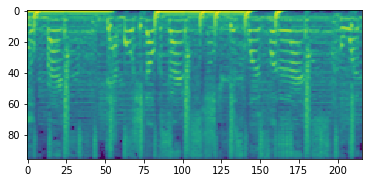

In [0]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(spectrograms_dir + 'train/000JCyEkMFumqCZQJAORiQ.png')
imgplot = plt.imshow(img)
plt.show()

In [0]:
time_steps = img.shape[1]
frequency_bands = img.shape[0]

In [0]:
embedding_norm = embedding_model.wv.syn0 #.copy()
for i, vector in enumerate(embedding_norm):
    norm = np.linalg.norm(embedding_norm[i], 2)
#    if norm != 0:
#        embedding_norm[i, :] = embedding_norm[i, :] / norm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [0]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LeakyReLU,\
        SeparableConv2D, MaxPooling2D, BatchNormalization, Flatten

input_shape = (frequency_bands, time_steps, 1)
input_img = Input(input_shape, name='input')
x = input_img

x = SeparableConv2D(32, 3, padding="same")(x)
x = LeakyReLU(0.2)(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(rate=0.2)(x)

x = SeparableConv2D(64, 3, padding="same")(x)
x = LeakyReLU(0.2)(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(rate=0.3)(x)

x = SeparableConv2D(128, 3, padding="same")(x)
x = LeakyReLU(0.2)(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(rate=0.4)(x)

shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(1024)(x)
x = LeakyReLU(0.2)(x)
x = Dropout(rate=0.5)(x)

In [0]:
from keras.layers import Lambda

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

In [0]:
from keras.layers import Reshape, UpSampling2D

latent_dim = 512
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z = Lambda(sampling)([z_mean, z_log_var])
decoder_input = Input(K.int_shape(z)[1:])

x = Dense(np.prod(shape_before_flattening[1:]))(decoder_input)
x = LeakyReLU(0.2)(x)
x = Dropout(rate=0.5)(x)

x = Reshape(shape_before_flattening[1:])(x)

x = Conv2DTranspose(64, 3, padding="same")(x)
x = LeakyReLU(0.2)(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Dropout(rate=0.4)(x)

x = Conv2DTranspose(32, 3, padding="same")(x)
x = LeakyReLU(0.2)(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Dropout(rate=0.3)(x)

x = Conv2DTranspose(1, 3, padding="same", activation="sigmoid")(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Dropout(rate=0.2)(x)

decoder = Model(decoder_input, x)
decoder.summary()

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 41472)             21275136  
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 41472)             0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 41472)             0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 12, 27, 128)       0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 12, 27, 64)        73792     
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 12, 27, 64)        0         
__________

In [0]:
from keras.layers import Layer
from keras.metrics import mae

class CustomVariationalLayer(Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = mae(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

In [0]:
from keras.callbacks import ModelCheckpoint, Callback
from scipy.stats import norm

def plot_samples():
    samples = 10
    for i in range(samples):
        z_sample = np.array([np.random.uniform(size=(latent_dim))])
        z_sample = np.tile(z_sample, 1).reshape(1, latent_dim)
        img = decoder.predict(z_sample, batch_size=1)[0, :, :, 0]
        imgplot = plt.imshow(img)
        plt.show()

class Test(Callback):
    def on_train_begin(self, logs={}):
        self.train_losses = []
        self.val_losses = []
        return
 
    def on_epoch_end(self, epoch, logs={}):
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        ax=plt.figure(figsize=(10,4)).gca()
        plt.plot(1+np.arange(len(self.train_losses)), np.array(self.train_losses))
        plt.plot(1+np.arange(len(self.val_losses)), np.array(self.val_losses))
        plt.title('loss', fontsize=18)
        plt.ylabel('loss', fontsize=18)
        plt.legend(['train', 'val'], loc='upper left')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show()
        plot_samples()
        return
    
def spectrogram_generator(directory, label_file, batch_size = 64):
    path = directory + label_file + '/'
    files = []
    for filename in os.listdir(path):
        files.append(filename)
    indices = np.random.permutation(len(files))
    i = 0
    while True:
        # Select files (paths/indices) for the batch
        start = i * batch_size
        end = start + batch_size
        batch = indices[start:end]
        batch_X = numpy.array([np.expand_dims(mpimg.imread(path + files[j]), axis=2) for j in batch])
        batch_Y = None
        i = i + 1
        if end >= len(files):
            i = 0
        yield(batch_X, batch_Y)

In [0]:
y = CustomVariationalLayer()([input_img, z_decoded])
vae = Model(input_img, y)
vae.compile(optimizer="rmsprop", loss=None) # rmsprop is reported to work better in non-stationary environments
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 96, 216, 1)   0                                            
__________________________________________________________________________________________________
separable_conv2d_16 (SeparableC (None, 96, 216, 32)  73          input[0][0]                      
__________________________________________________________________________________________________
leaky_re_lu_36 (LeakyReLU)      (None, 96, 216, 32)  0           separable_conv2d_16[0][0]        
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 48, 108, 32)  0           leaky_re_lu_36[0][0]             
__________________________________________________________________________________________________
dropout_40

Epoch 1/5000
1000/1000 [==============================] - 331s 331ms/step - loss: 0.2598 - val_loss: 0.2959


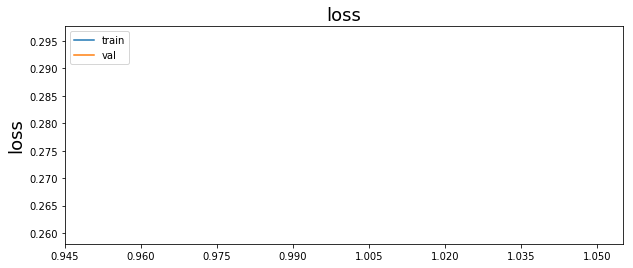

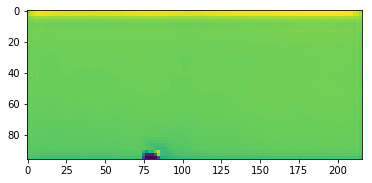

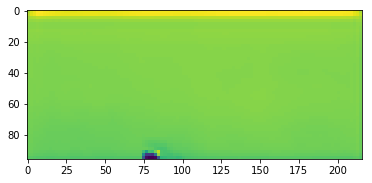

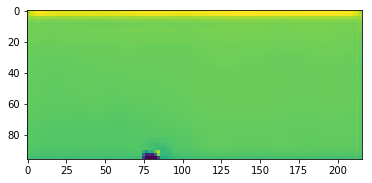

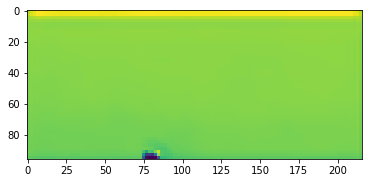

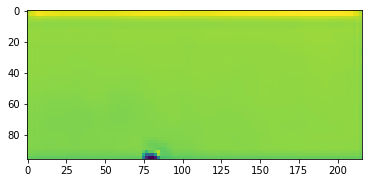

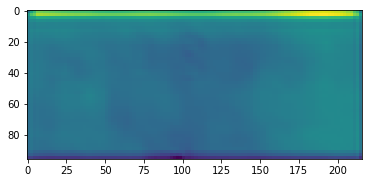

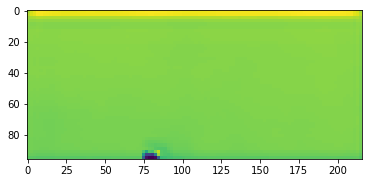

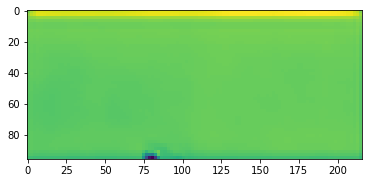

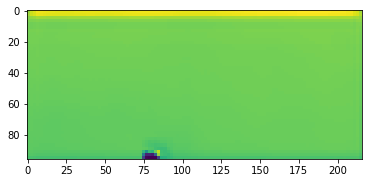

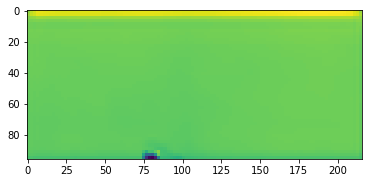

Epoch 2/5000
1000/1000 [==============================] - 319s 319ms/step - loss: 0.1677 - val_loss: 0.1310


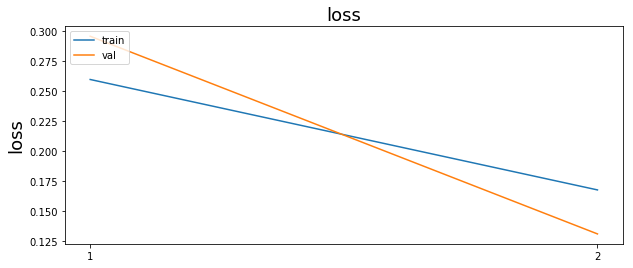

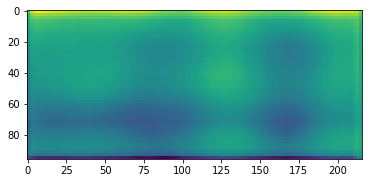

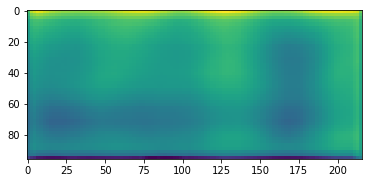

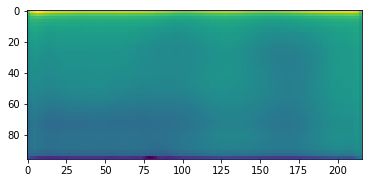

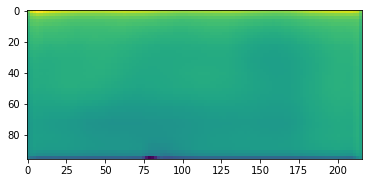

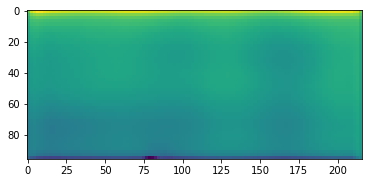

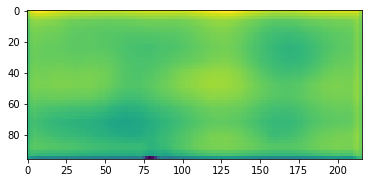

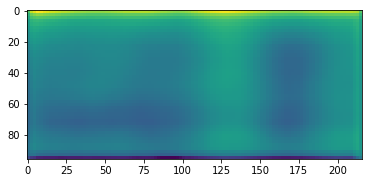

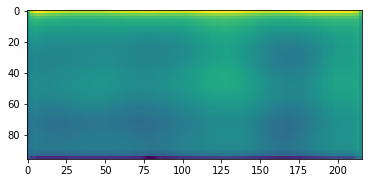

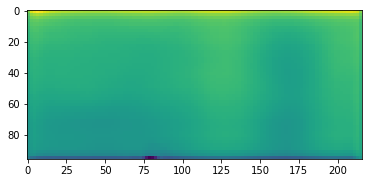

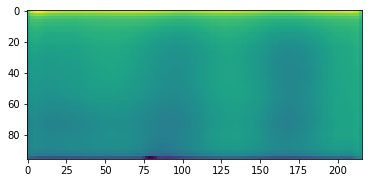

Epoch 3/5000
1000/1000 [==============================] - 321s 321ms/step - loss: 0.1658 - val_loss: 0.1397


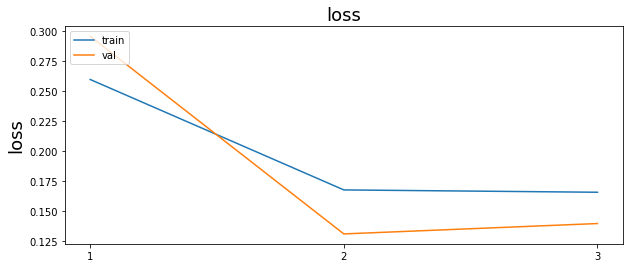

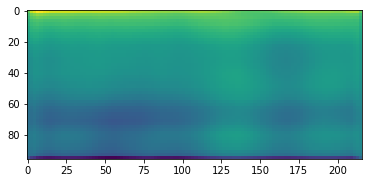

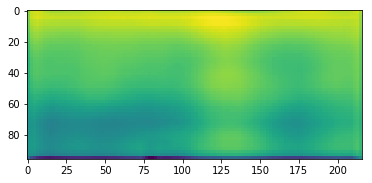

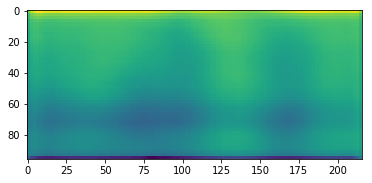

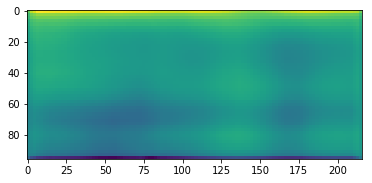

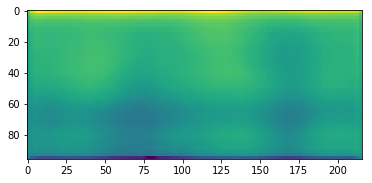

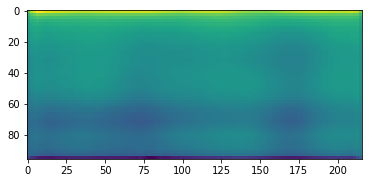

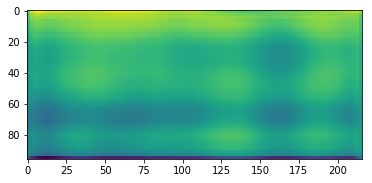

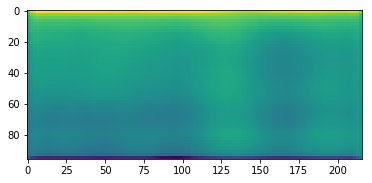

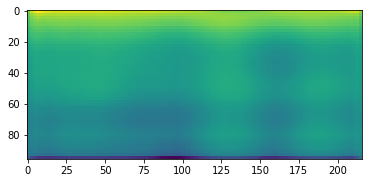

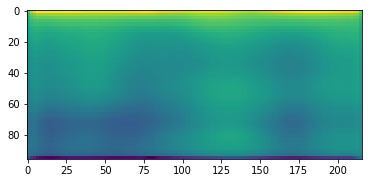

Epoch 4/5000
1000/1000 [==============================] - 318s 318ms/step - loss: 0.1646 - val_loss: 0.1337


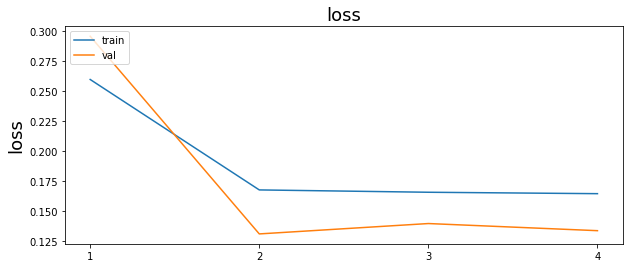

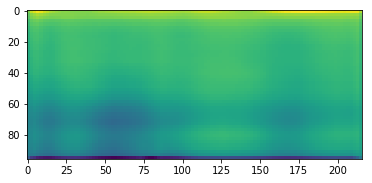

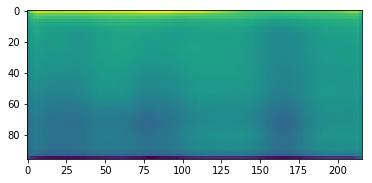

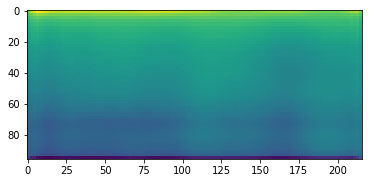

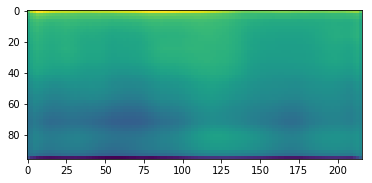

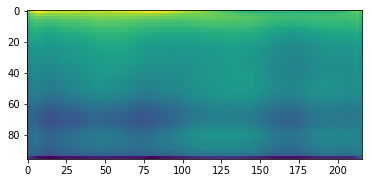

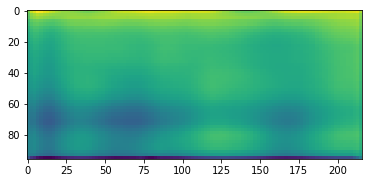

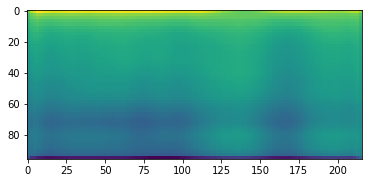

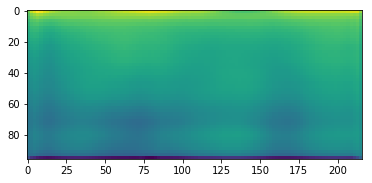

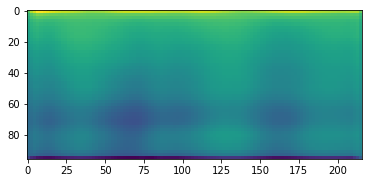

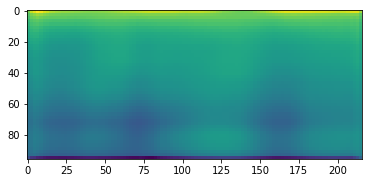

Epoch 5/5000
1000/1000 [==============================] - 319s 319ms/step - loss: 0.1638 - val_loss: 0.1377


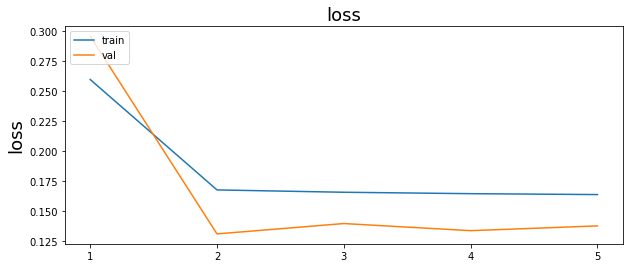

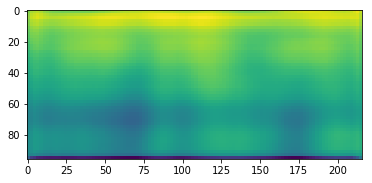

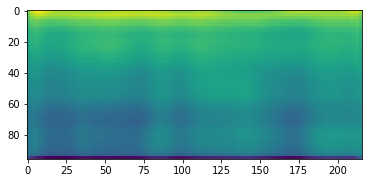

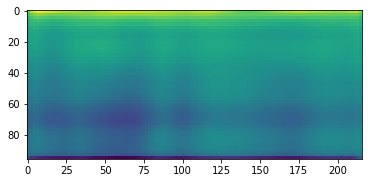

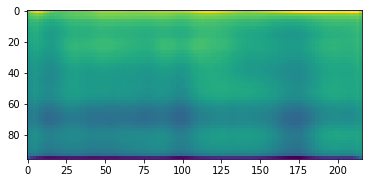

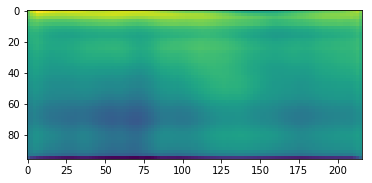

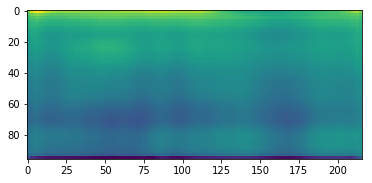

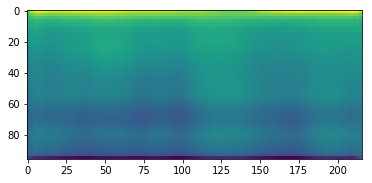

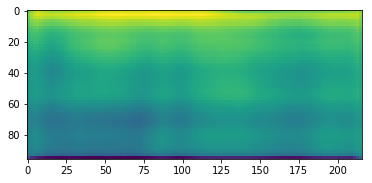

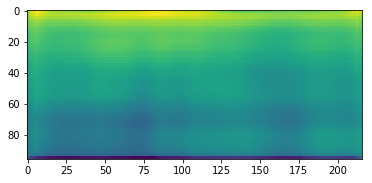

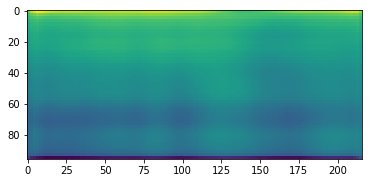

Epoch 6/5000
1000/1000 [==============================] - 318s 318ms/step - loss: 0.1629 - val_loss: 0.1465


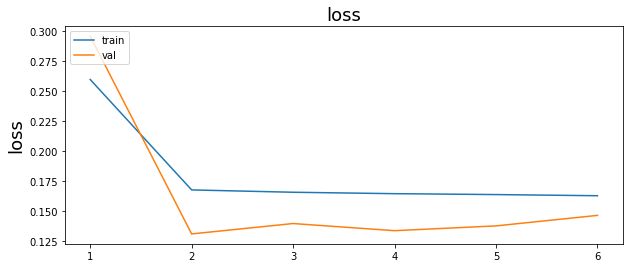

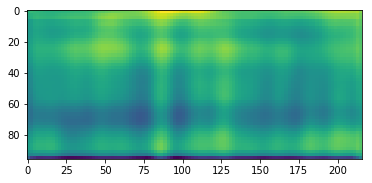

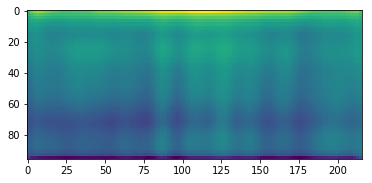

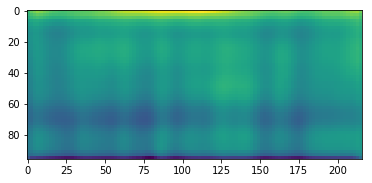

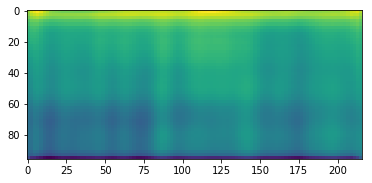

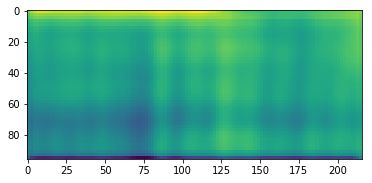

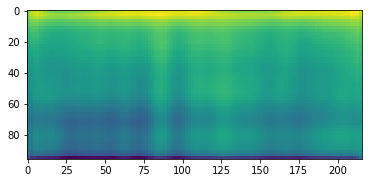

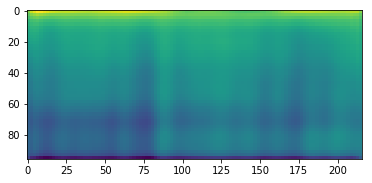

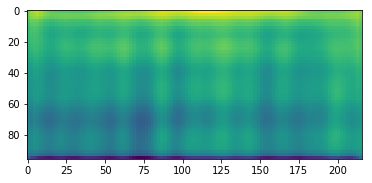

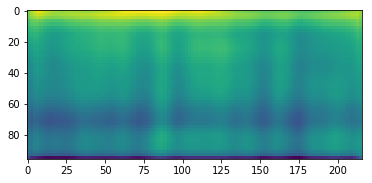

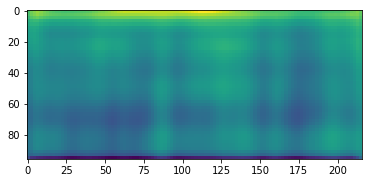

Epoch 7/5000
1000/1000 [==============================] - 318s 318ms/step - loss: 0.1616 - val_loss: 0.1232


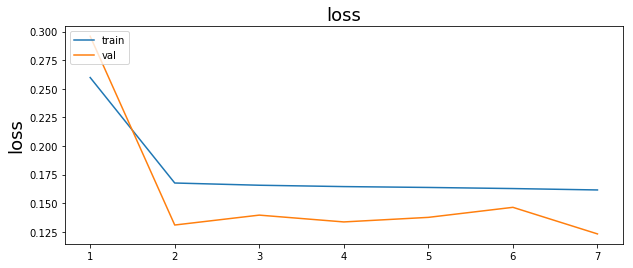

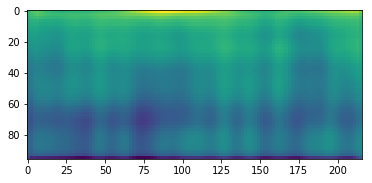

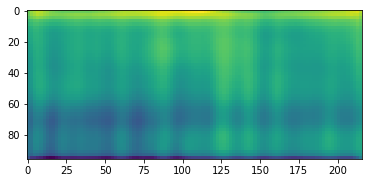

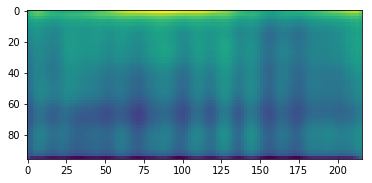

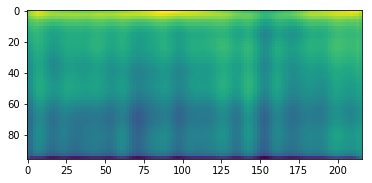

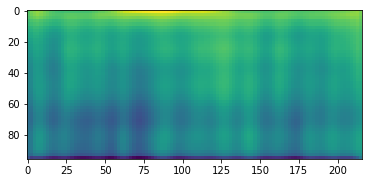

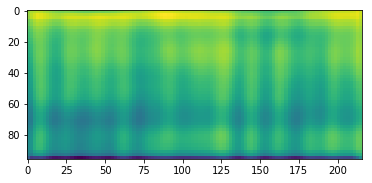

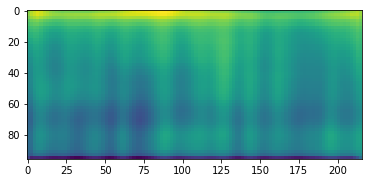

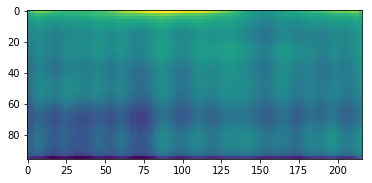

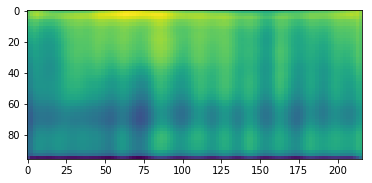

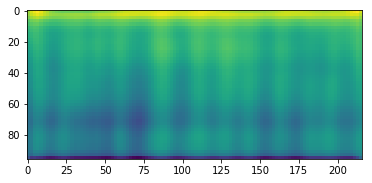

Epoch 8/5000
1000/1000 [==============================] - 318s 318ms/step - loss: 0.1607 - val_loss: 0.1416


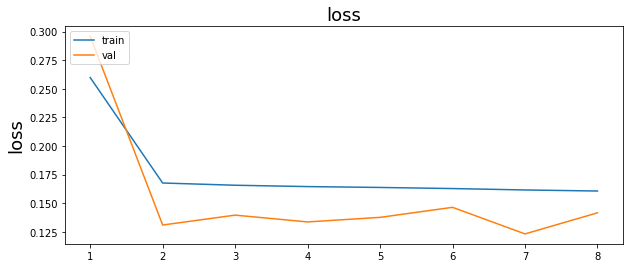

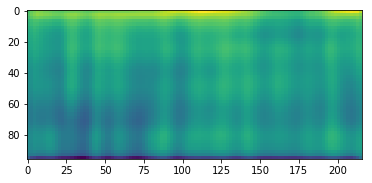

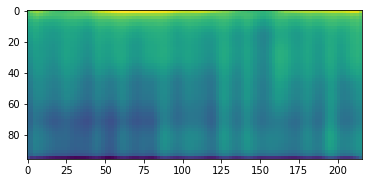

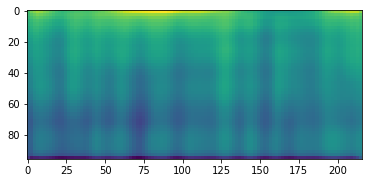

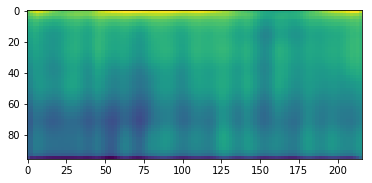

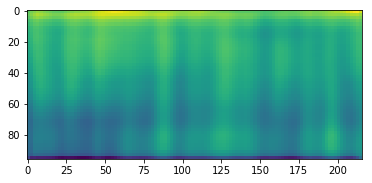

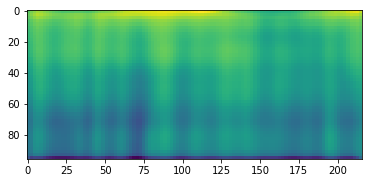

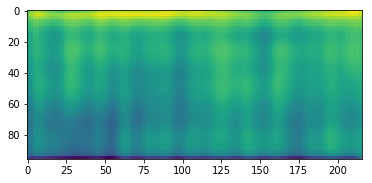

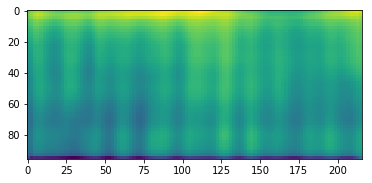

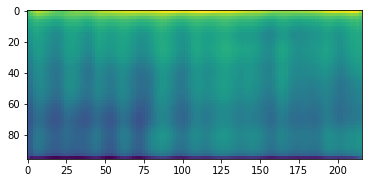

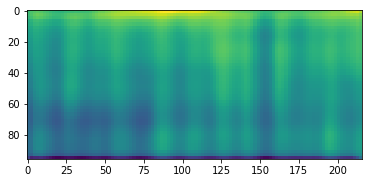

Epoch 9/5000
1000/1000 [==============================] - 318s 318ms/step - loss: 0.1600 - val_loss: 0.1292


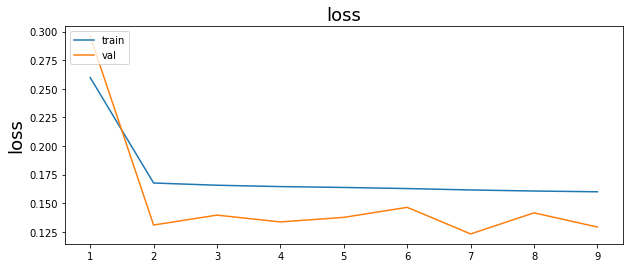

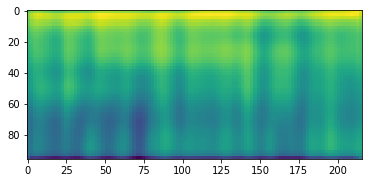

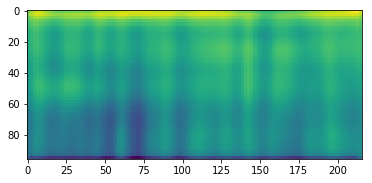

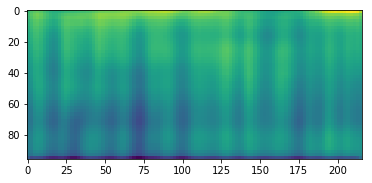

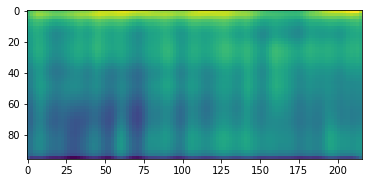

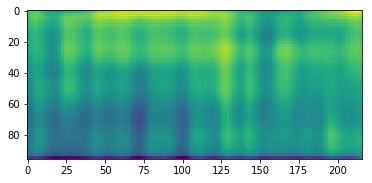

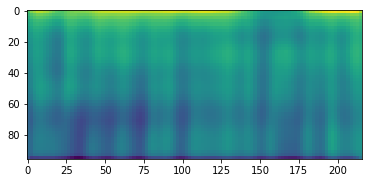

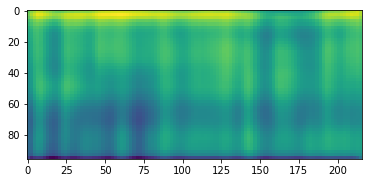

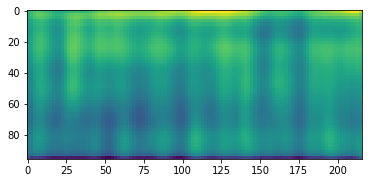

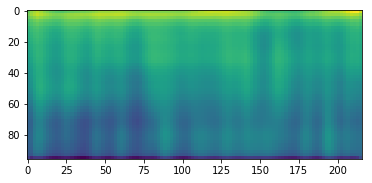

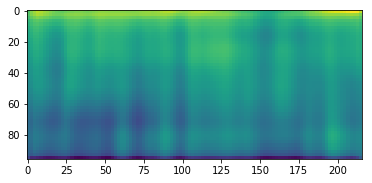

Epoch 10/5000
1000/1000 [==============================] - 317s 317ms/step - loss: 0.1596 - val_loss: 0.1167


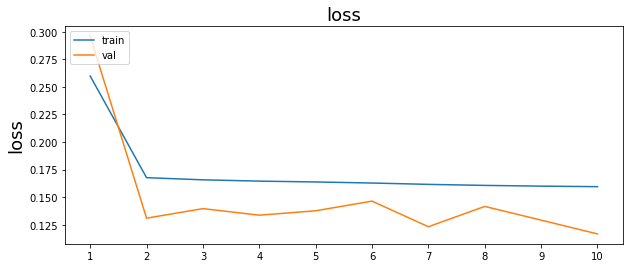

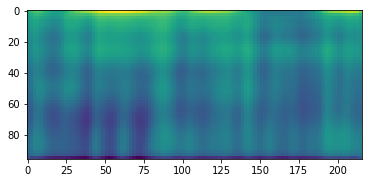

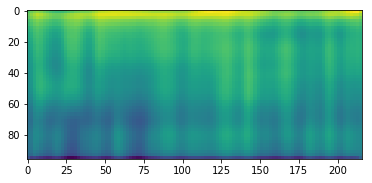

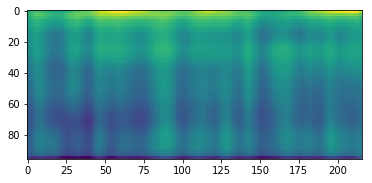

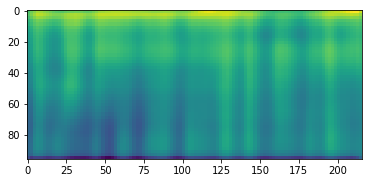

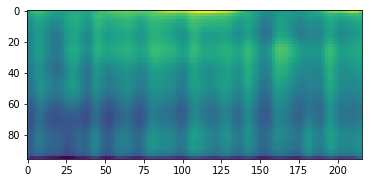

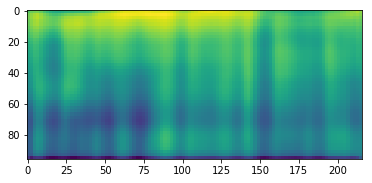

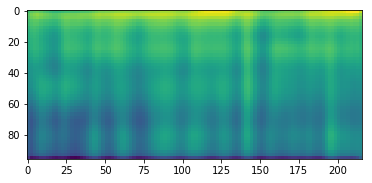

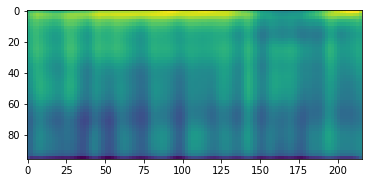

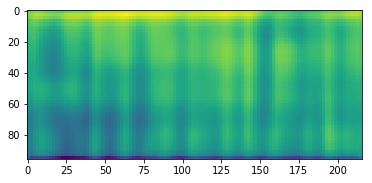

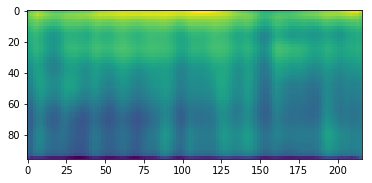

Epoch 11/5000
1000/1000 [==============================] - 319s 319ms/step - loss: 0.1592 - val_loss: 0.1374


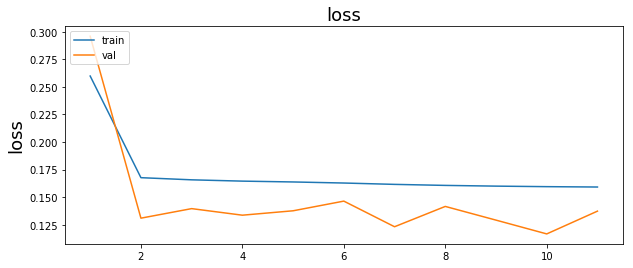

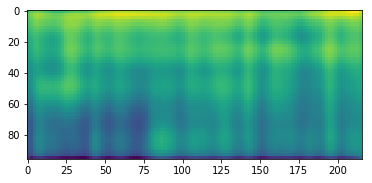

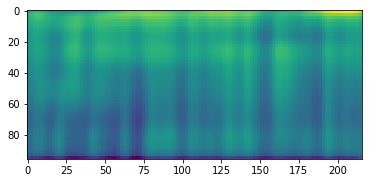

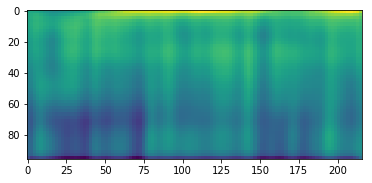

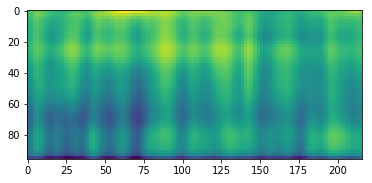

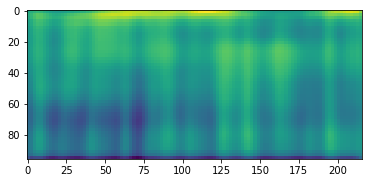

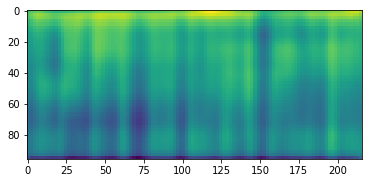

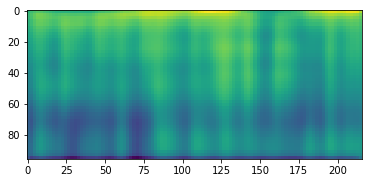

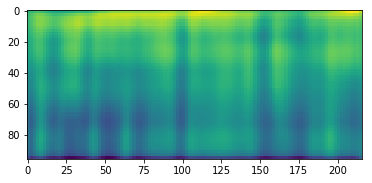

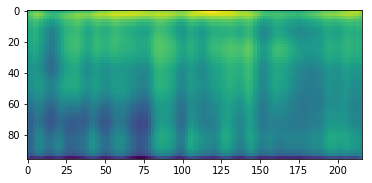

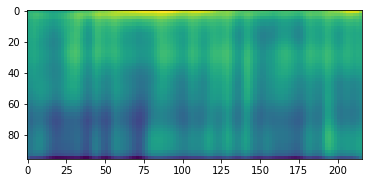

Epoch 12/5000
1000/1000 [==============================] - 319s 319ms/step - loss: 0.1589 - val_loss: 0.1276


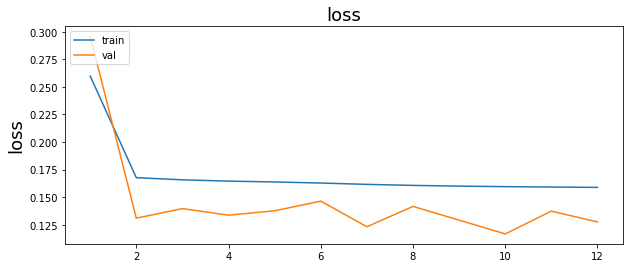

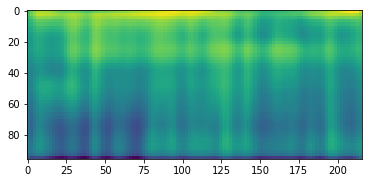

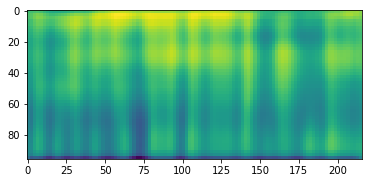

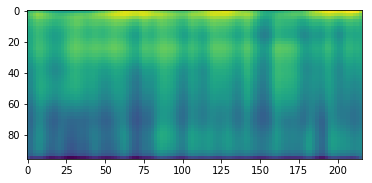

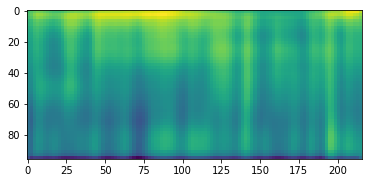

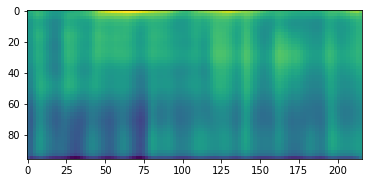

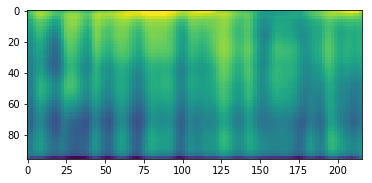

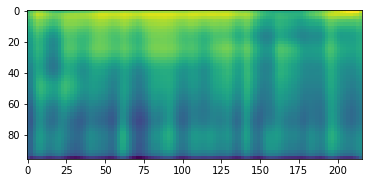

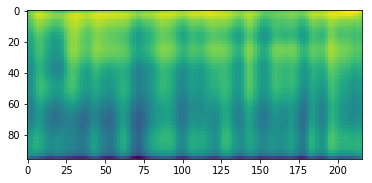

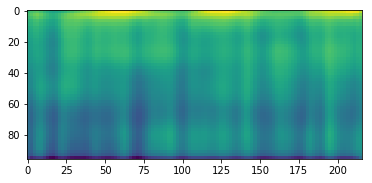

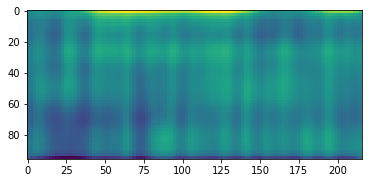

Epoch 13/5000
1000/1000 [==============================] - 318s 318ms/step - loss: 0.1587 - val_loss: 0.1271


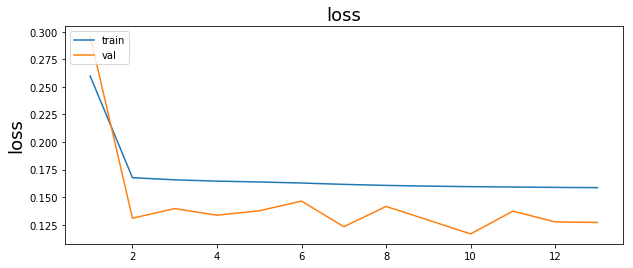

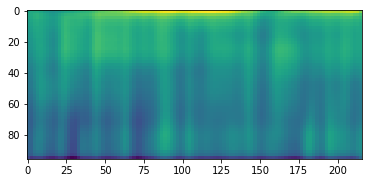

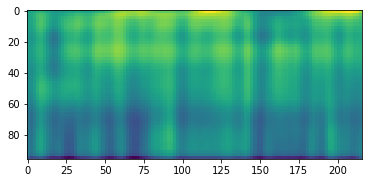

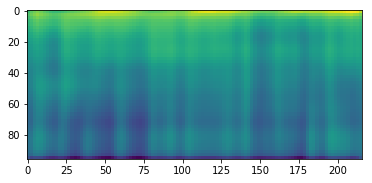

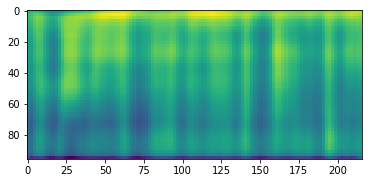

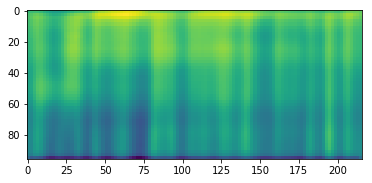

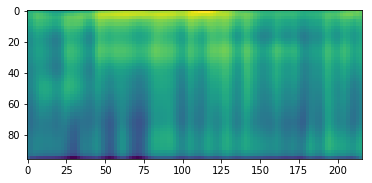

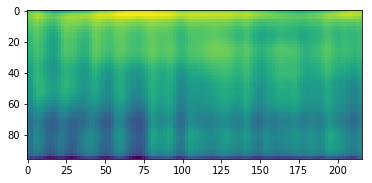

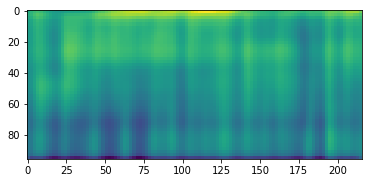

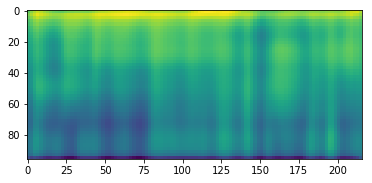

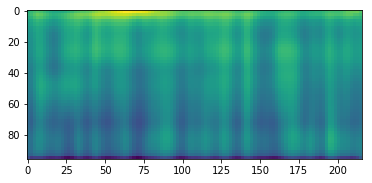

Epoch 14/5000
1000/1000 [==============================] - 317s 317ms/step - loss: 0.1584 - val_loss: 0.1311


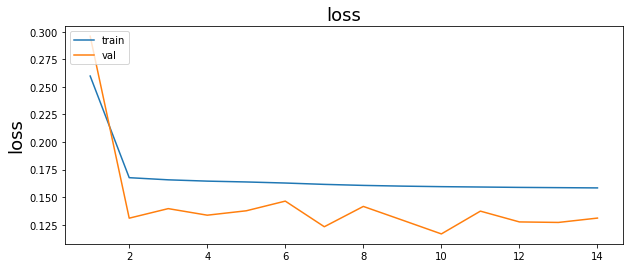

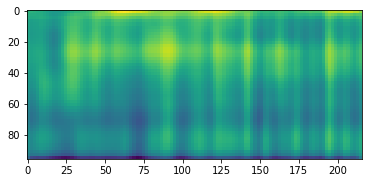

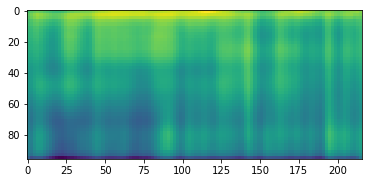

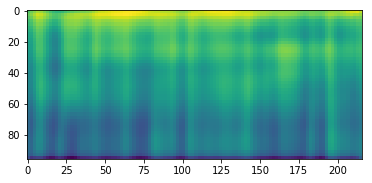

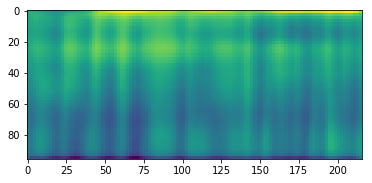

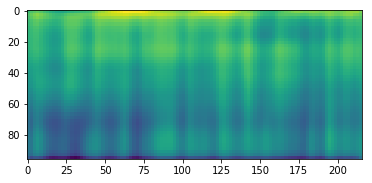

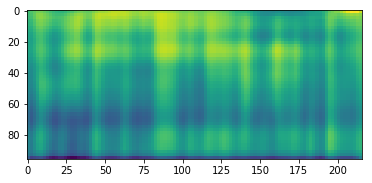

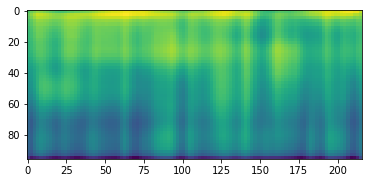

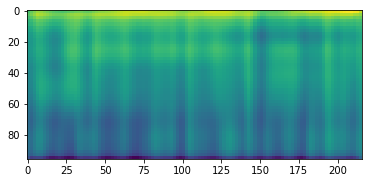

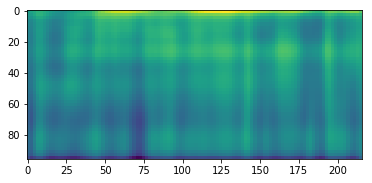

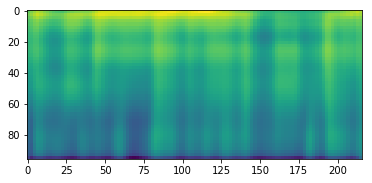

Epoch 15/5000
1000/1000 [==============================] - 317s 317ms/step - loss: 0.1583 - val_loss: 0.1110


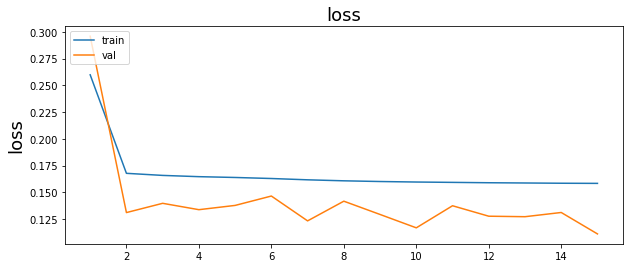

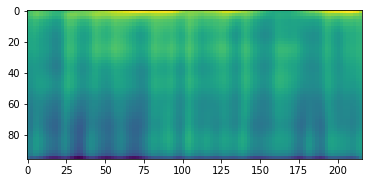

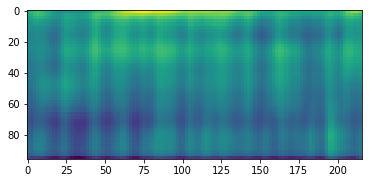

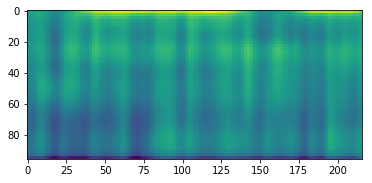

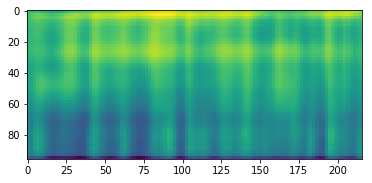

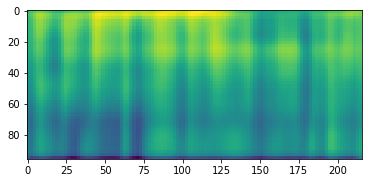

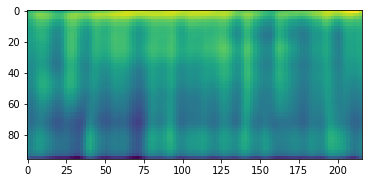

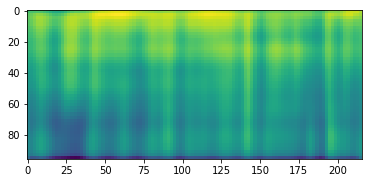

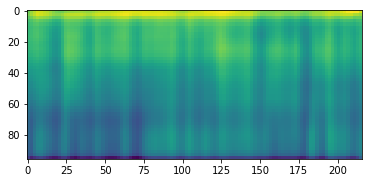

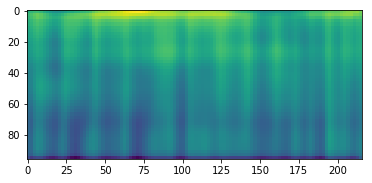

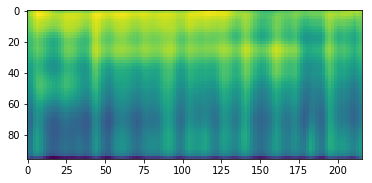

Epoch 16/5000
1000/1000 [==============================] - 317s 317ms/step - loss: 0.1582 - val_loss: 0.1332


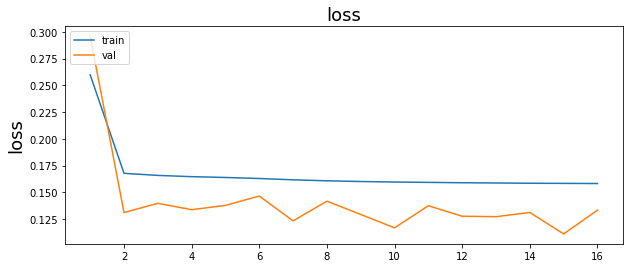

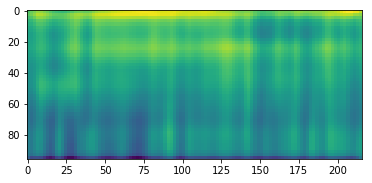

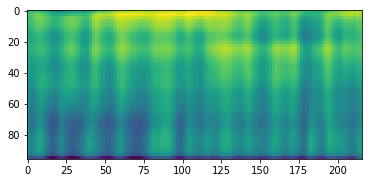

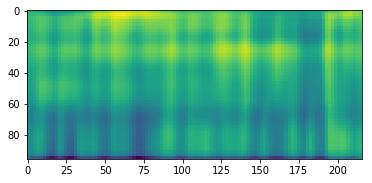

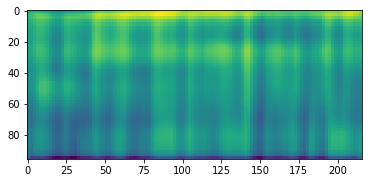

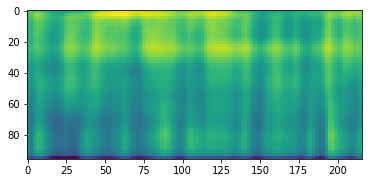

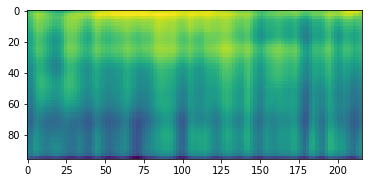

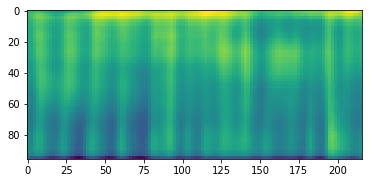

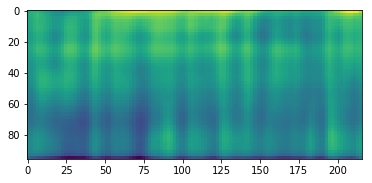

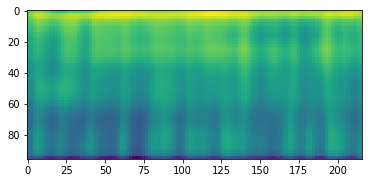

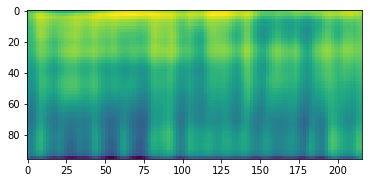

Epoch 17/5000
1000/1000 [==============================] - 318s 318ms/step - loss: 0.1581 - val_loss: 0.1270


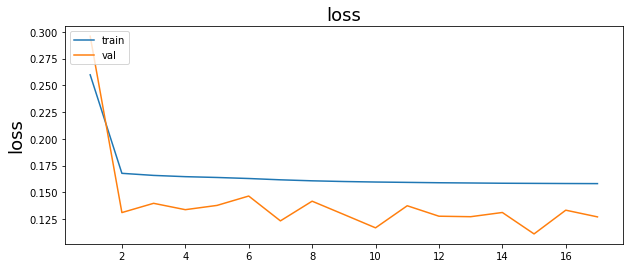

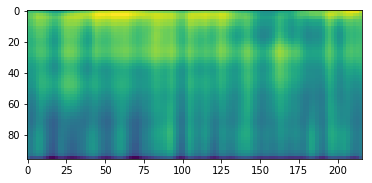

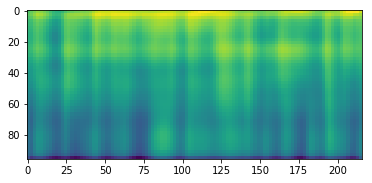

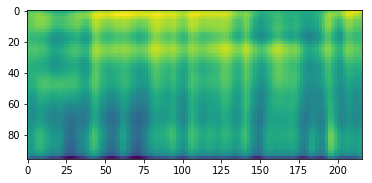

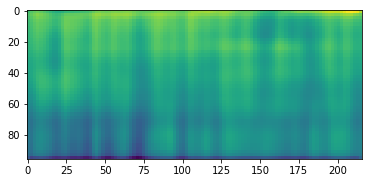

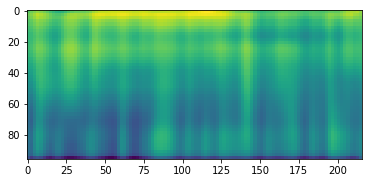

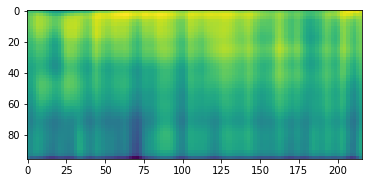

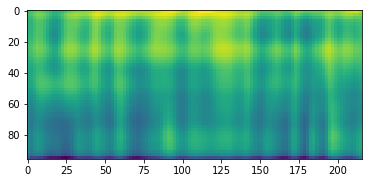

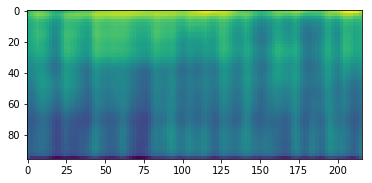

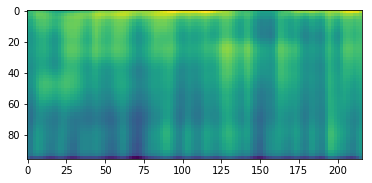

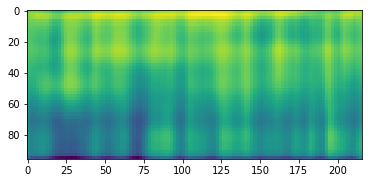

Epoch 18/5000
1000/1000 [==============================] - 317s 317ms/step - loss: 0.1580 - val_loss: 0.1098


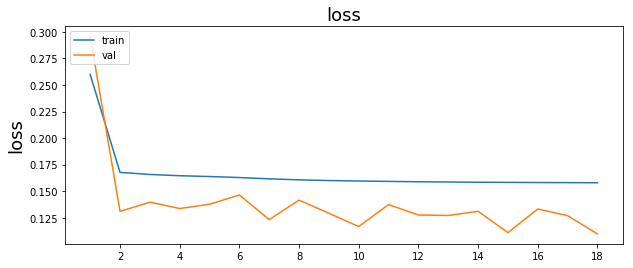

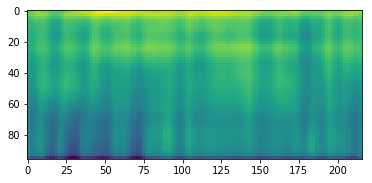

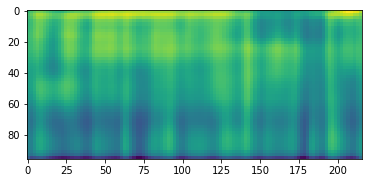

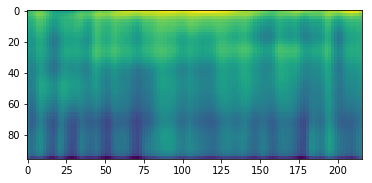

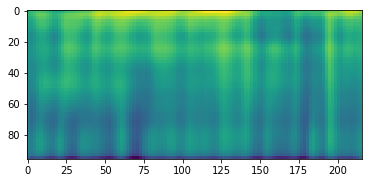

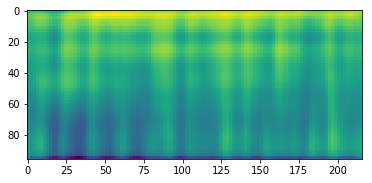

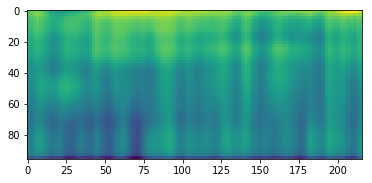

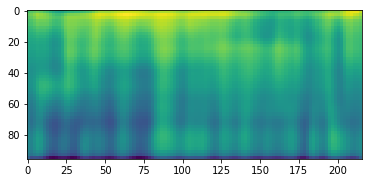

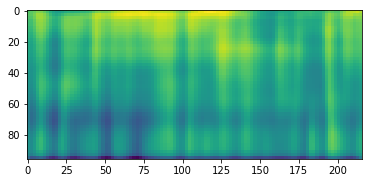

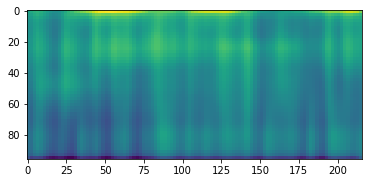

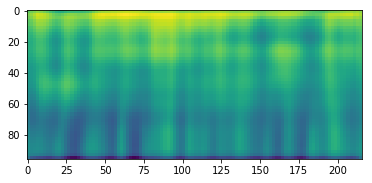

Epoch 19/5000
1000/1000 [==============================] - 318s 318ms/step - loss: 0.1579 - val_loss: 0.1153


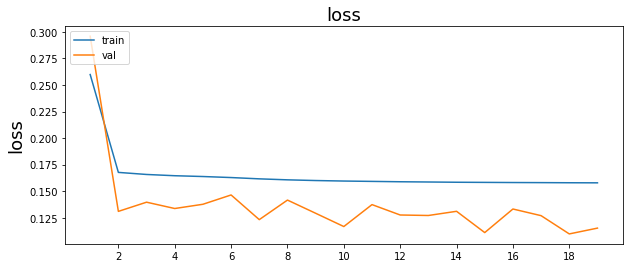

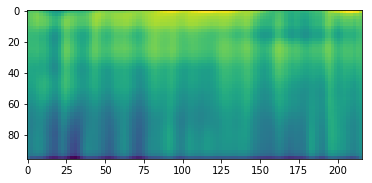

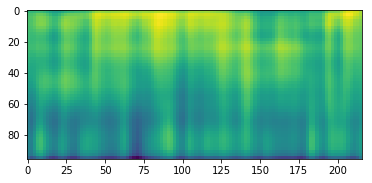

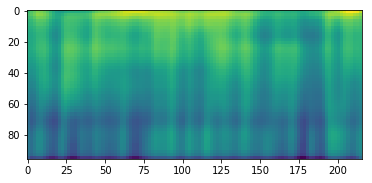

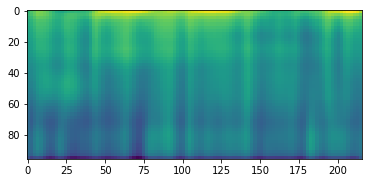

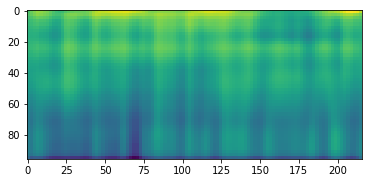

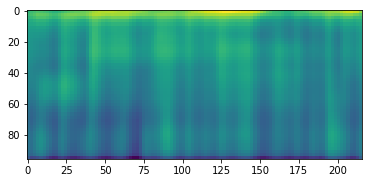

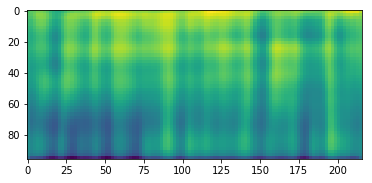

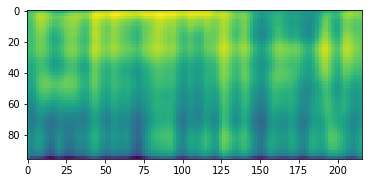

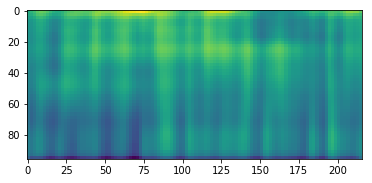

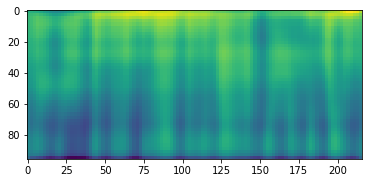

Epoch 20/5000
1000/1000 [==============================] - 320s 320ms/step - loss: 0.1578 - val_loss: 0.1311


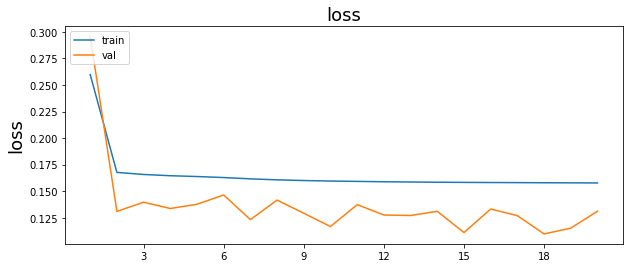

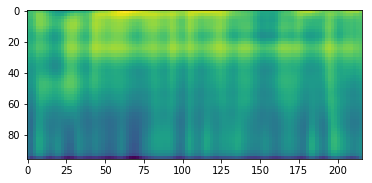

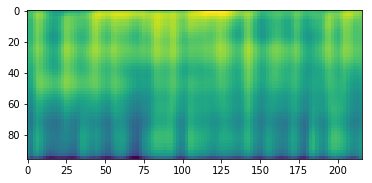

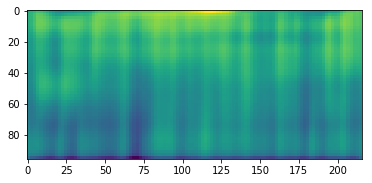

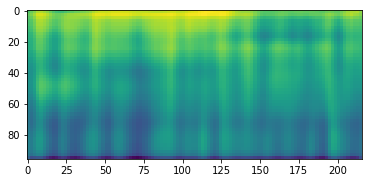

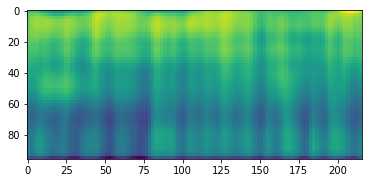

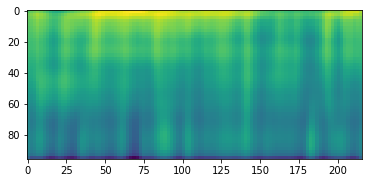

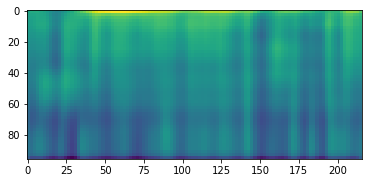

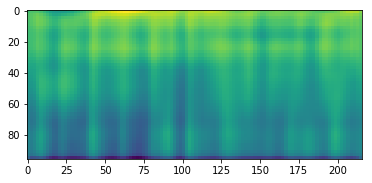

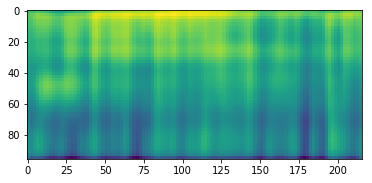

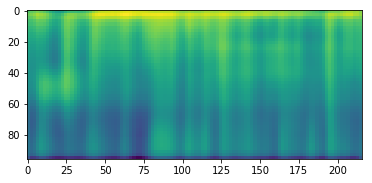

Epoch 21/5000
1000/1000 [==============================] - 319s 319ms/step - loss: 0.1577 - val_loss: 0.1145


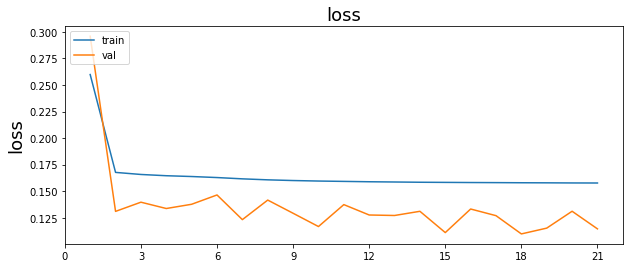

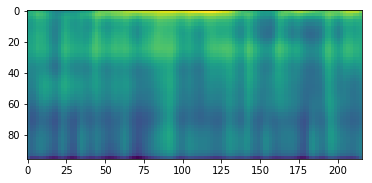

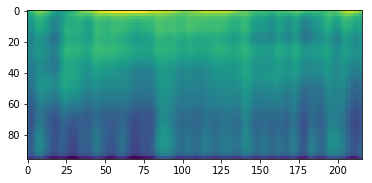

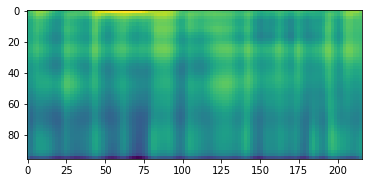

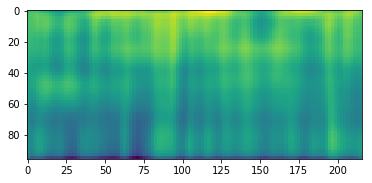

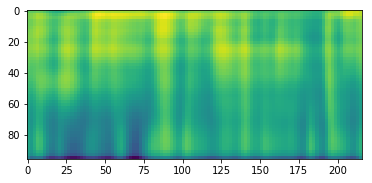

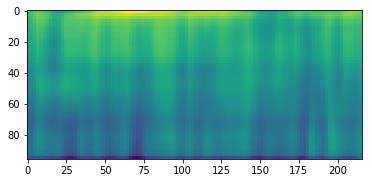

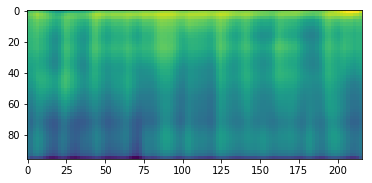

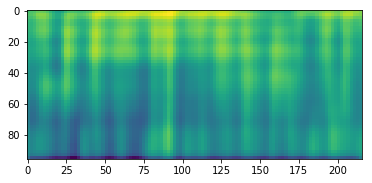

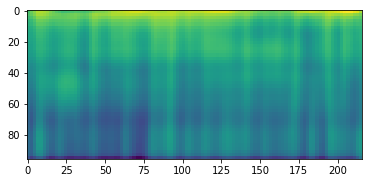

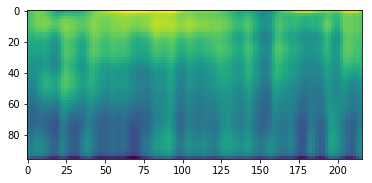

Epoch 22/5000
1000/1000 [==============================] - 319s 319ms/step - loss: 0.1576 - val_loss: 0.1265


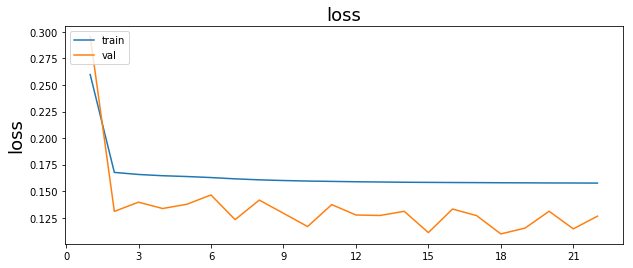

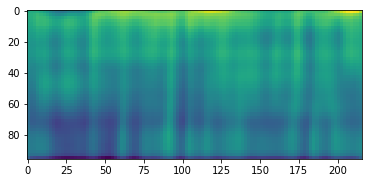

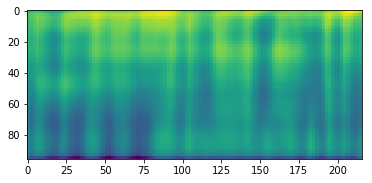

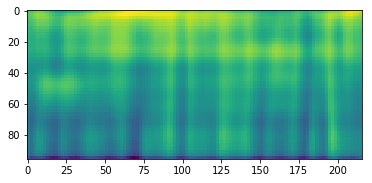

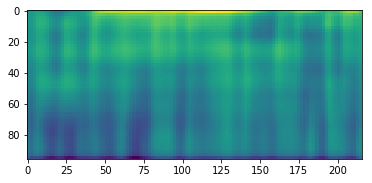

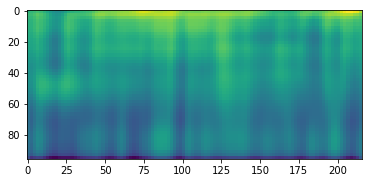

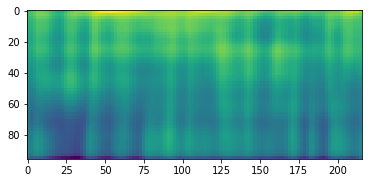

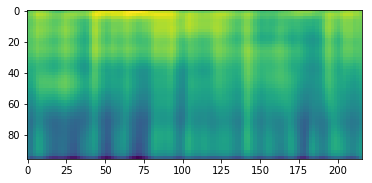

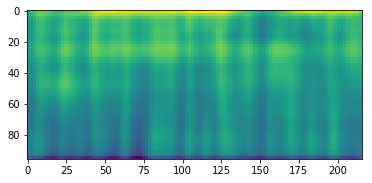

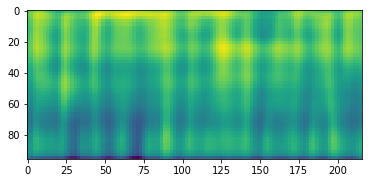

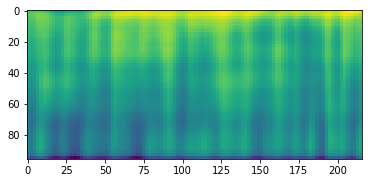

Epoch 23/5000
1000/1000 [==============================] - 320s 320ms/step - loss: 0.1576 - val_loss: 0.1074


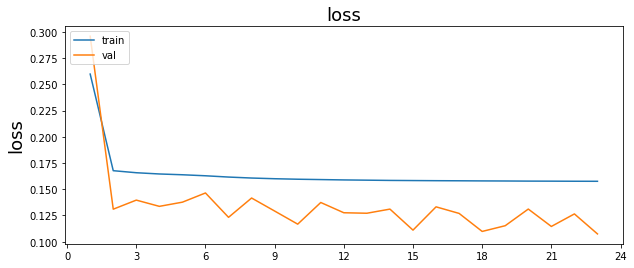

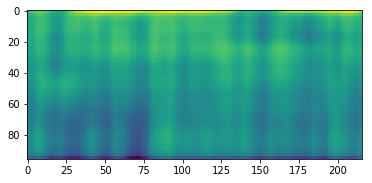

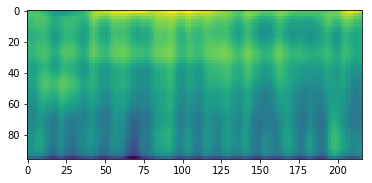

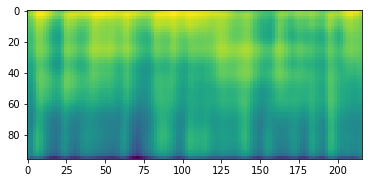

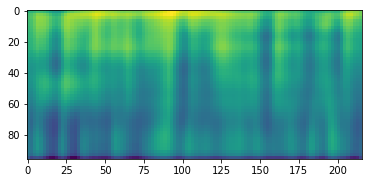

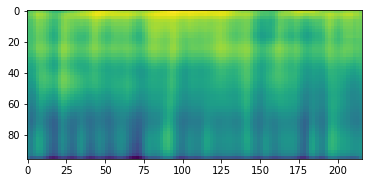

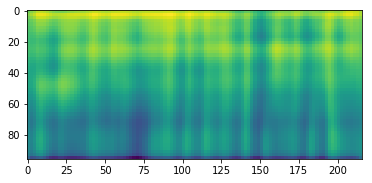

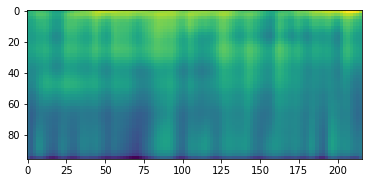

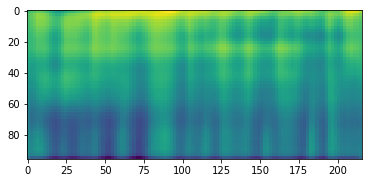

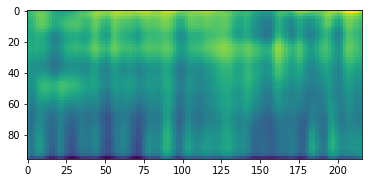

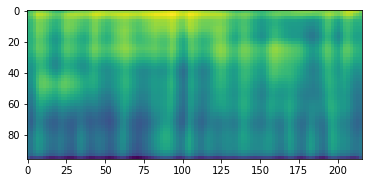

Epoch 24/5000
1000/1000 [==============================] - 318s 318ms/step - loss: 0.1575 - val_loss: 0.1249


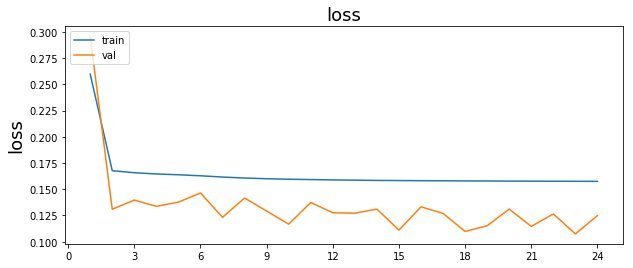

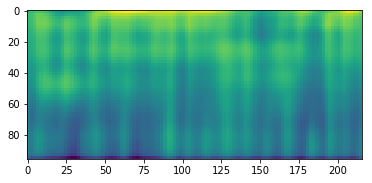

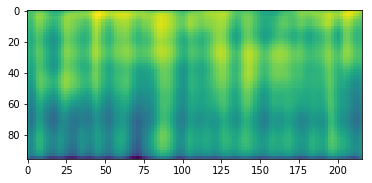

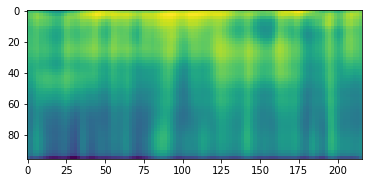

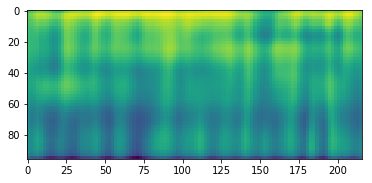

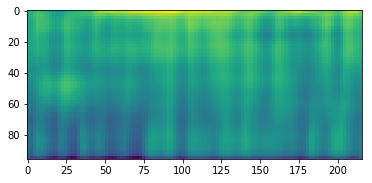

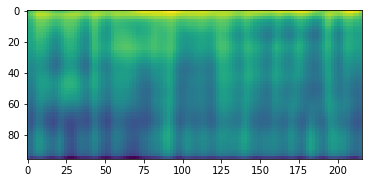

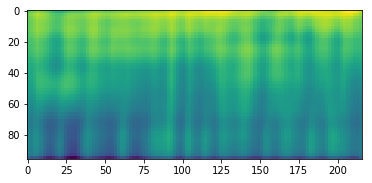

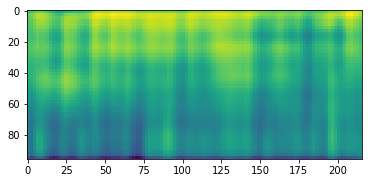

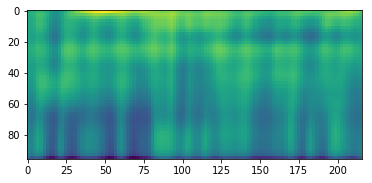

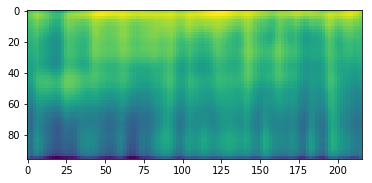

Epoch 25/5000
 227/1000 [=====>........................] - ETA: 3:53 - loss: 0.1575

In [0]:
#vae.load_weights(checkpoint_dir + 'speccy_vae')
vae.fit_generator(spectrogram_generator(spectrograms_dir, 'train', batch_size=128),
                  steps_per_epoch=1000,
                  epochs=5000,
                  validation_data=spectrogram_generator(spectrograms_dir, 'val', batch_size=128),
                  validation_steps=100,
                  callbacks=[ModelCheckpoint(checkpoint_dir + 'speccy_vae', save_best_only=True), Test()])

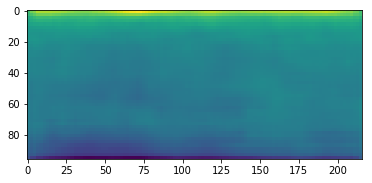

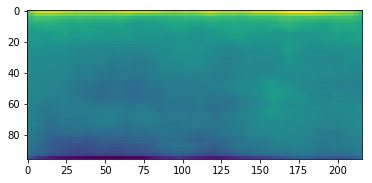

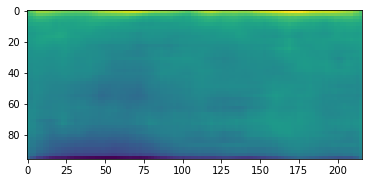

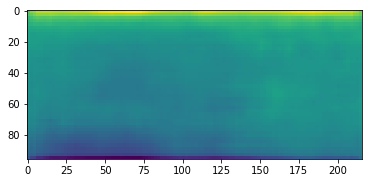

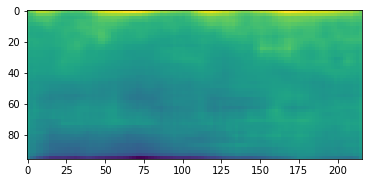

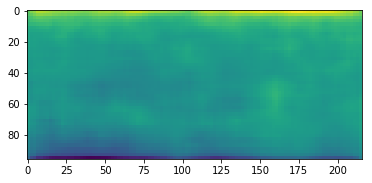

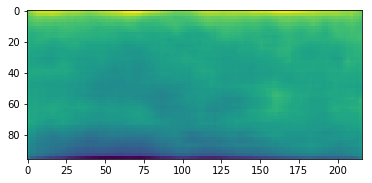

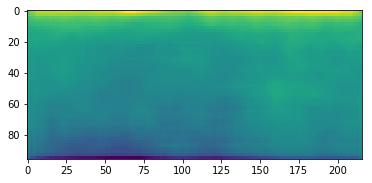

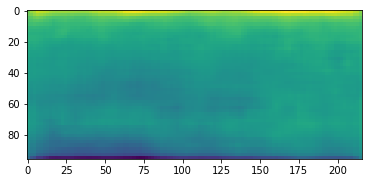

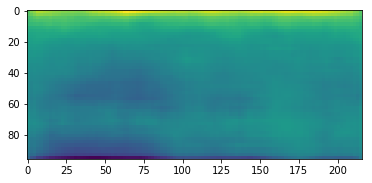

In [0]:
plot_samples()

### Search for a particular song id

In [0]:
search = 'oasis'
for track in tracks:
    if tracks[track][0].lower().find(search.lower()) != -1 and track in embedding_model.wv.vocab:
        print(f'{track} : {tracks[track][0]} : {tracks[track][1]}')